# Import Libraries

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, SpatialDropout1D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import metrics

import re
import nltk
from nltk.corpus import stopwords


import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()



# Import Dataset


In [ ]:
tweet_dataset = pd.read_csv('dataset.csv',
                            encoding = "ISO-8859-1",
                            usecols=[0, 5],
                            names=["label","tweet"])

# Explore & Visualize Dataset

In [ ]:
print(tweet_dataset.shape) 

(1600000, 2)


In [ ]:
tweet_dataset['label'].replace([4, 0],[1, 0], inplace=True) 
# 4 -> 1 
# 0 -> 0

In [ ]:
tweet_dataset.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
tweet_dataset['label'].value_counts()

1    800000
0    800000
Name: label, dtype: int64

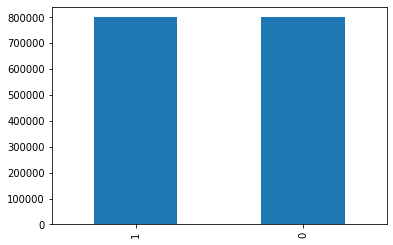

In [ ]:
tweet_dataset['label'].value_counts().plot(kind='bar')

In [ ]:
import random 
random.seed(41)
tweet_dataset.iloc[random.sample(range(1, 1600000), 10), :]

,label,tweet
799059,0,awww RIP Farrah Fawcett bummer @takianballard...
696726,0,Morning Tweet Peeps &amp; FB Folks. Had plans ...
483854,0,back still aching . hmmm.. it's been a while ...
348205,0,@vrikis I just noticed that you have in- follo...
808725,1,wow just got how it was great a bunch of new c...
1212026,1,loves his PraiseTEAM family I will never forg...
1447314,1,Sprinkers need some work #fb
594454,0,@garpods22 I know! I can't believe we haven't ...
1159850,1,@mosessaur U sure know that !!!
580463,0,wishes that it would just rain already. My ki...


# Preprocess Dataset

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

# remove URL
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

def clean_train_data(x):
  text = x
  text = text.lower()   # convert to lower case
  text = re.sub('\[.*?\]', '', text) # remove square brackets
  text = re.sub(r'[^\w\s]','',text) # remove punctuation
  text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
  text = re.sub('\n', '', text) # remove carriage return
  text = cleaning_URLs(text) # remove URL
  text = text.split()
  stop_words = set(stopwords.words('english')) # remove stopwords
  text = [w for w in text if not w in stop_words] 
  lemma = nltk.wordnet.WordNetLemmatizer() # lemmatization
  text = ' '.join([lemma.lemmatize(word) for word in text])

  return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tweet_dataset['tweet'] = tweet_dataset.tweet.apply(lambda x : clean_train_data(x)) # apply to tweet column
tweet_dataset.head()

,label,tweet
0,0,switchfoot bummer shoulda got david carr third...
1,0,upset cant update facebook texting might cry r...
2,0,kenichan dived many time ball managed save res...
3,0,whole body feel itchy like fire
4,0,nationwideclass behaving im mad cant see


In [ ]:
max_features = 6000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(tweet_dataset['tweet'].values)

X = token.texts_to_sequences(tweet_dataset['tweet'].values)
X = pad_sequences(X,maxlen=20)   

In [ ]:
labels = to_categorical(tweet_dataset['label'], num_classes=2)
labels.shape

(1600000, 2)

In [ ]:
Y = labels

# Split Dataset

In [ ]:
X_train, xtmp, y_train, ytmp = train_test_split(X,Y, test_size=0.25, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(xtmp,ytmp, test_size=0.4, random_state=42)

In [ ]:
X_train
X_validation
X_test

array([[   0,    0,    0, ..., 1565,    7,  933],
       [   0,    0,    0, ...,   31,  631,   37],
       [   0,    0,    0, ..., 5983, 1275,  138],
       ...,
       [   0,    0,    0, ...,   13,   13,  592],
       [   0,    0,    0, ..., 5418,   31, 4193],
       [   0,    0,    0, ..., 3028, 3028, 3028]], dtype=int32)

In [ ]:
y_train
y_validation
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Build Model

In [ ]:
embed_dim = 128
lstm_out = 96

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 128)           768000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 96)                86400     
_________________________________________________________________
dense (Dense)                (None, 2)                 194       
Total params: 854,594
Trainable params: 854,594
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [ ]:
callbacks = [ tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)]

In [ ]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    epochs=8, 
                    validation_data = (X_validation,y_validation),
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/8
4688/4688 [==============================] - 865s 179ms/step - loss: 0.4950 - accuracy: 0.7573 - val_loss: 0.4570 - val_accuracy: 0.7824
Epoch 2/8
4688/4688 [==============================] - 828s 177ms/step - loss: 0.4509 - accuracy: 0.7860 - val_loss: 0.4496 - val_accuracy: 0.7869
Epoch 3/8
4688/4688 [==============================] - 826s 176ms/step - loss: 0.4426 - accuracy: 0.7910 - val_loss: 0.4449 - val_accuracy: 0.7898
Epoch 4/8
4688/4688 [==============================] - 825s 176ms/step - loss: 0.4360 - accuracy: 0.7947 - val_loss: 0.4438 - val_accuracy: 0.7900
Epoch 5/8
4688/4688 [==============================] - 823s 176ms/step - loss: 0.4319 - accuracy: 0.7973 - val_loss: 0.4427 - val_accuracy: 0.7913
Epoch 6/8
4688/4688 [==============================] - 824s 176ms/step - loss: 0.4264 - accuracy: 0.8003 - val_loss: 0.4422 - val_accuracy: 0.7921
Epoch 7/8
4688/4688 [==============================] - 825s 176ms/step - loss: 0.4227 - accuracy: 0.8027 - val_loss: 0

# Plot Graph

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


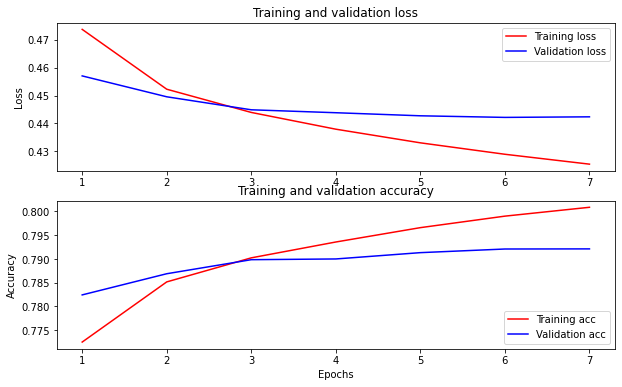

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Evaluate Model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

5000/5000 [==============================] - 37s 7ms/step - loss: 0.4425 - accuracy: 0.7922
Loss: 0.4425494074821472
Accuracy: 0.7922312617301941


# Classification Report

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true=y_true,y_pred=pred, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.80      0.79      0.79     79905
    Positive       0.79      0.80      0.79     80095

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



# Confusion Matrix

Text(0.5, 384.16, 'Predicted label')

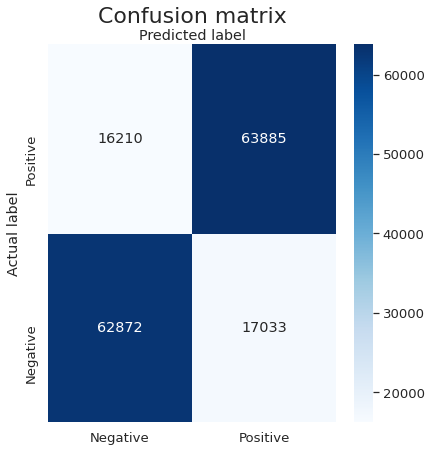

In [ ]:
import seaborn as sns
%matplotlib inline

CM = confusion_matrix(y_true, pred)

fig, ax = plt.subplots(figsize=(6,6)) 

sns.set(font_scale=1.2)
sns.heatmap(CM, annot=True, cmap="Blues" ,fmt='g',xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive']) 
ax.xaxis.set_label_position("top") 
ax.set_ylim([0,2])

plt.tight_layout()
plt.title('Confusion matrix', y=1,fontsize=22) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

# Make Prediction

In [ ]:
sentences = ['Nobody cares', 'It is the best day of my life',
             'Please leave me alone', 'Fed up with my life', 'Having my favourite curly fries in McD right now']

In [ ]:
pred_sentences = token.texts_to_sequences(sentences)
pred_sentences = pad_sequences(pred_sentences)

In [ ]:
true_label = []

for i in range(len(sentences)):
  tf_outputs = model(tf.convert_to_tensor(pred_sentences))
  tf_predictions = tf.nn.softmax(tf_outputs[i], axis=-1)
  labels = ['Negative','Positive']
  label = tf.argmax(tf_predictions,None)
  label = np.array(label)
  true_label.append(label)

In [ ]:
print(true_label)

[array(0), array(1), array(0), array(0), array(1)]


In [ ]:
for i in range(len(pred_sentences)):
  if true_label[i] == 0:
    result = "negative"
  if true_label[i] == 1:
    result = "positive"
  print(sentences[i], ": \n", result)

Nobody cares : 
 negative
It is the best day of my life : 
 positive
Please leave me alone : 
 negative
Fed up with my life : 
 negative
Having my favourite curly fries in McD right now : 
 positive


In [ ]:
model.save("/content/drive/LSTM_Model")

In [ ]:
model.save("/content/drive/lstm_model.h5")